In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")

print('modules loaded')


modules loaded


In [3]:
data_dir = r"D:\CAPSTONE 400A\cse438\lung_colon_image_set\lung_image_sets"
filepaths = []
labels = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        filepaths.append(file_path)
        label = os.path.basename(root)
        labels.append(label)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
labels = df['labels']
print(df)


                                               filepaths    labels
0      D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_aca
1      D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_aca
2      D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_aca
3      D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_aca
4      D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_aca
...                                                  ...       ...
14995  D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_scc
14996  D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_scc
14997  D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_scc
14998  D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_scc
14999  D:\CAPSTONE 400A\cse438\lung_colon_image_set\l...  lung_scc

[15000 rows x 2 columns]


In [4]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
epochs = 1
k = 2  

def get_callbacks(model_name):
    callbacks = []
    checkpoint = ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_accuracy', mode='max')
    callbacks.append(checkpoint)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
    callbacks.append(reduce_lr)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    callbacks.append(early_stopping)
    return callbacks

def build_model():
    base_model = tf.keras.applications.Xception(input_shape=img_shape, include_top=False, weights='imagenet')
    base_model.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.55)(x)
    y = Dense(512, activation='relu')(x)
    y = Dropout(0.55)(y)
    predictions = Dense(class_count, activation='softmax', name='final')(y)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adamax(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [5]:
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=123)
fold_no = 1
accuracies = []
histories = []

for train_index, test_index in skf.split(df['filepaths'], df['labels']):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

    tr_gen = ImageDataGenerator()
    ts_gen = ImageDataGenerator()

    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                           target_size=img_size, class_mode='categorical',
                                           color_mode='rgb', shuffle=True, batch_size=batch_size)

    test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                          target_size=img_size, class_mode='categorical',
                                          color_mode='rgb', shuffle=False, batch_size=batch_size)

    g_dict = train_gen.class_indices
    classes = list(g_dict.keys())
    class_count = len(classes)

    model = build_model()
    callbacks = get_callbacks(f'Xception_fold_{fold_no}')

    history = model.fit(train_gen,
                        epochs=epochs,
                        validation_data=test_gen,
                        callbacks=callbacks)
    
    histories.append(history.history)

    ts_length = len(test_df)
    test_batch_size = min(32, ts_length)
    test_steps = ts_length // test_batch_size

    test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)
    print(f"Fold {fold_no} - Test Loss: ", test_score[0])
    print(f"Fold {fold_no} - Test Accuracy: ", test_score[1])

    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)
    print(f"Classification Report for Fold {fold_no}")
    print(classification_report(test_gen.classes, y_pred, target_names=classes))

    accuracies.append(test_score[1])
    fold_no += 1

print(f'Mean accuracy over {k} folds: {np.mean(accuracies)}')
print(f'Standard Deviation over {k} folds: {np.std(accuracies)}')


Found 7500 validated image filenames belonging to 3 classes.
Found 7500 validated image filenames belonging to 3 classes.
235/235 [==============================] - ETA: 0s - loss: 0.1208 - accuracy: 0.9531 
Epoch 1: saving model to model.Xception_fold_1.h5
234/234 [==============================] - 703s 3s/step - loss: 0.7367 - accuracy: 0.8742
Fold 1 - Test Loss:  0.7367375493049622
Fold 1 - Test Accuracy:  0.8741987347602844
235/235 [==============================] - 774s 3s/step
Classification Report for Fold 1
              precision    recall  f1-score   support

    lung_aca       0.73      1.00      0.84      2500
      lung_n       1.00      0.99      1.00      2500
    lung_scc       1.00      0.63      0.77      2500

    accuracy                           0.87      7500
   macro avg       0.91      0.87      0.87      7500
weighted avg       0.91      0.87      0.87      7500

Found 7500 validated image filenames belonging to 3 classes.
Found 7500 validated image filenames 

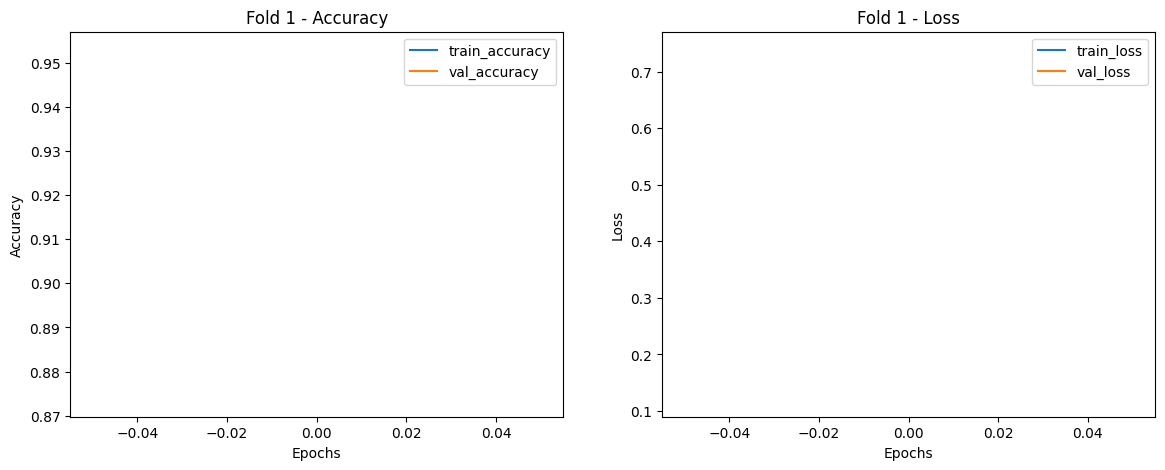

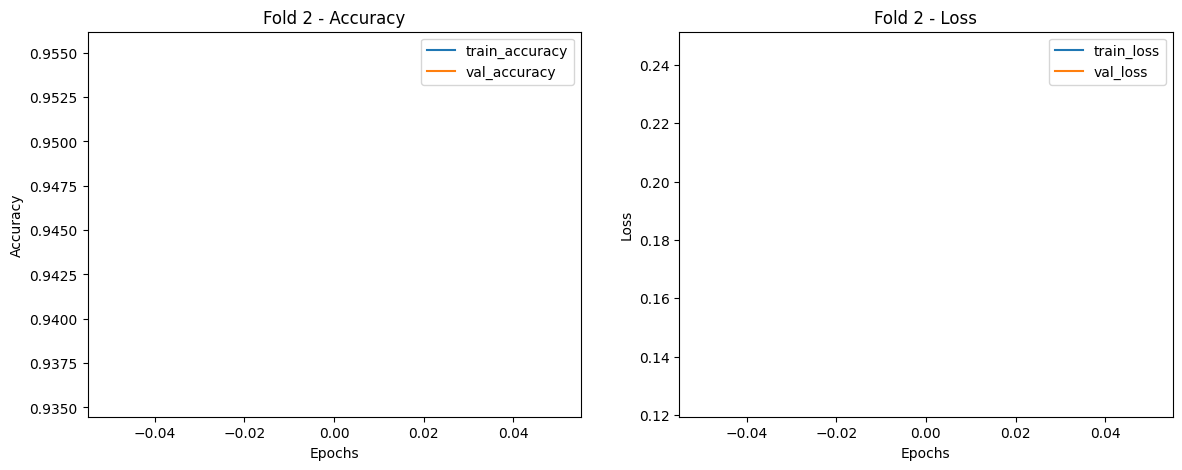

In [6]:
for i, history in enumerate(histories):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='train_accuracy')
    plt.plot(history['val_accuracy'], label='val_accuracy')
    plt.title(f'Fold {i+1} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.title(f'Fold {i+1} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


Found 7500 validated image filenames belonging to 3 classes.
235/235 [==============================] - 766s 3s/step


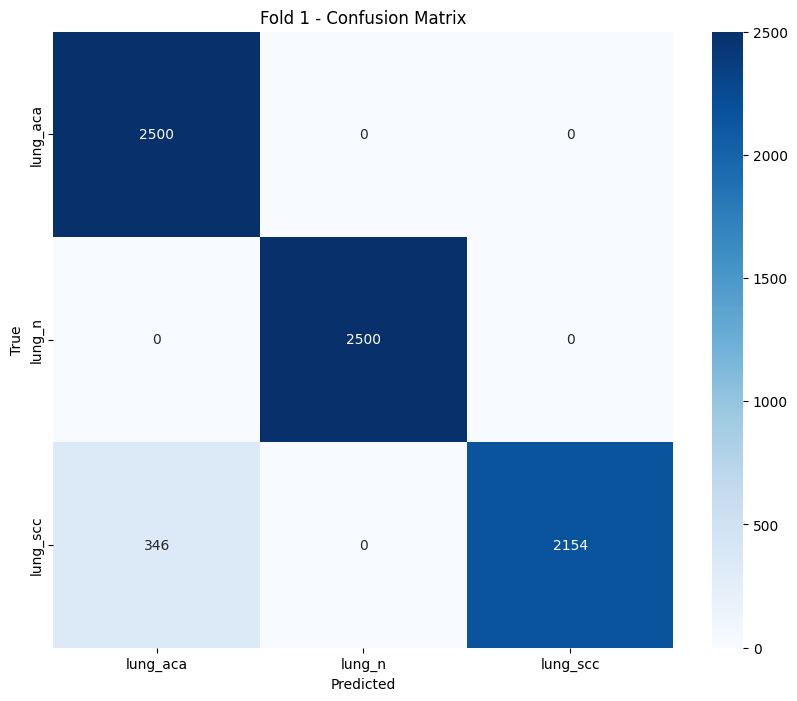

Found 7500 validated image filenames belonging to 3 classes.
 22/235 [=>............................] - ETA: 11:09

In [ ]:
for i, (train_index, test_index) in enumerate(skf.split(df['filepaths'], df['labels'])):
    test_df = df.iloc[test_index]
    ts_gen = ImageDataGenerator()
    test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                          target_size=img_size, class_mode='categorical',
                                          color_mode='rgb', shuffle=False, batch_size=batch_size)
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)
    cm = confusion_matrix(test_gen.classes, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Fold {i+1} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
